# Preprocessing data

In this notebook, we reproduce the typical steps here for processing spectra
    
For this example, we create two Gaussian signals randomly sampled along two different X axis, with backgrounds


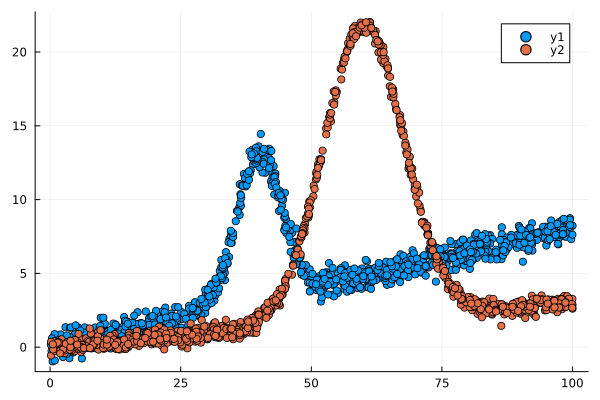

In [1]:
using Spectra, Plots

# we create a fake signal with 
x_1 = rand(1000)*100
x_2 = rand(1000)*100

# create a signal that is the combination of two gaussian peaks plus a background
background_1 = 0.08 * x_1
background_2 = 0.03 * x_2

# some noise
noise_1 = 0.5*randn(1000)
noise_2 = 0.3*randn(1000)

y_1 = gaussian(x_1, 10.0, 40., 5.) .+ background_1 .+ noise_1
y_2 = gaussian(x_2, 20.0, 60., 9.) .+ background_2 .+ noise_2
scatter(x_1, y_1)
scatter!(x_2, y_2)

# First possible steps

We can do the following steps (not necessarily in this order):
    
- the X values are randomly sorted, we can solve that using `sortsp`
- We may like to get our spectra on the same X axis for convenience
- Backgrounds are present: we can remove them
- Signals are noisy: we can smooth them

### 1/ Sort X Axis

We can sort the data by passing an array of spectra. After that we should have not problem plotting things with lines for instance!

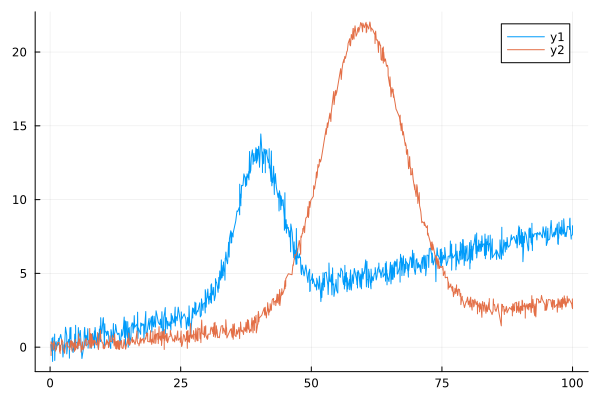

In [2]:
spectrum_1 = flipsp([x_1 y_1])
spectrum_2 = flipsp([x_2 y_2])
plot(spectrum_1[:,1], spectrum_1[:, 2])
plot!(spectrum_2[:,1], spectrum_2[:, 2])

### 2/ Resample to have everything on the same X axis

Using `resample`, we get everything on the same X axis. As we have two spectra with two different X axis, we simply provide them in a Vector like this:

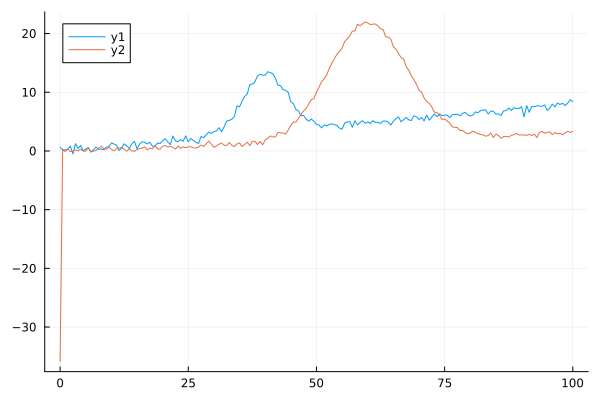

In [3]:
x_new = collect(0.:0.5:100)
spectra_ = [[x_1 y_1], [x_2 y_2]]
spectra_same_x = resample(spectra_, x_new)
plot(x_new, spectra_same_x)

We see tiny problems with the interpolation, we can solve them using another method from DataInterpolations.jl, such as Linear:

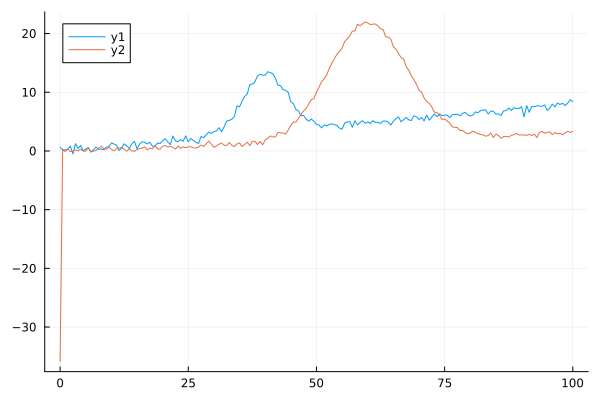

In [4]:
spectra_same_x = resample(spectra_, x_new, method="LinearInterpolation")
plot(x_new, spectra_same_x)


### 3/ Background

Now we can remove a background using the `baseline` function. Similarly to the other functions, you can pass x and y vectors or a x vectors and an array of y spectra. We will do that here:

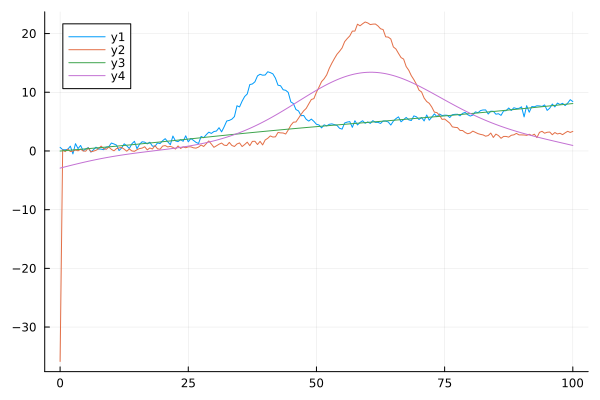

In [5]:
ys_corrected, ys_baselines = baseline(x_new, spectra_same_x, method="arPLS")
p1 = plot(x_new, spectra_same_x)
plot!(x_new, ys_baselines)
display(p1)

### 4/ Peak measurements

We can now measure the parameters of the peaks, for instance their centroid:

In [6]:
centroid(x_new, ys_corrected)

2-element Vector{Float64}:
 39.84135060908635
 59.17606856545107

or we can use the peakmeas function to get access to a bunch of parameters:

In [7]:
peakmeas(x_new, ys_corrected[:,1])

(10.018611000105183, 40.0, 5.0, 39.817149107186104)

or let's use the much better find_peaks() function introduced in 1.1:

Peak positions: [40.0]
Peak heights: [9.807133616560478]


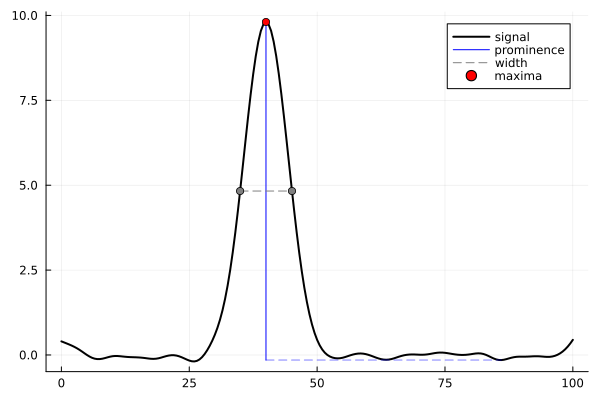

In [8]:
result = find_peaks(x_new, ys_corrected[:,1], window_size=1, min_width=2., min_height=2.0, smoothing=true)
println("Peak positions: ", result.peak_positions)
println("Peak heights: ", result.peak_heights)
result.plot_peaks

### 4/ Peak fitting!

We can retrieve the parameters of the two peaks using peak fitting too! We do a quick fit with very loose prior uncertainties on the peak parameters, and unrestrictive lower_bounds and upper_bounds:

In [9]:
peaks_info = [
        # (type, initial_params, prior uncertainties, lower_bounds, upper_bounds)
        (:gaussian, [10.5, 50.0, 5.0], [100.0, 100.0, 100.0], [0., 0., 0.], [Inf, Inf, Inf]),
        
    ]

result_1 = fit_peaks(x_new, ys_corrected[:,1], peaks_info, sigma=nothing, backend=:Optim)
result_2 = fit_peaks(x_new, ys_corrected[:,2], peaks_info, sigma=nothing, backend=:Optim)

(fit = [4.368925864673021e-42, 2.2047746062900477e-41, 1.0976537621514946e-40, 5.391109977379924e-40, 2.6121773639714702e-39, 1.2486444212599438e-38, 5.888254188977363e-38, 2.739340178305604e-37, 1.2572366542976895e-36, 5.6924568884834516e-36  …  1.1674735626406963e-14, 4.421417867509295e-15, 1.651915081781248e-15, 6.08871328352613e-16, 2.2139865502163708e-16, 7.94211336671393e-17, 2.810663376578216e-17, 9.81280653880805e-18, 3.3797866628616285e-18, 1.1484100595380875e-18], peak_results = Any[(type = :gaussian, params = [9.043367178631872, 59.94324337955525, 5.055836817575766], errors = [0.20704995939967816, 0.12170298467495223, 0.11194014107344868])], residuals = [-32.9342397760454, 3.01485647472615, 2.5863469390602223, 2.901627868258444, 2.377272570865151, 2.3350622361543385, 2.434625362263316, 2.1790618133206823, 2.3591399517624314, 1.9482961428486938  …  1.3719057530156251, 1.018962090300092, 1.4935696850998241, 1.3534518861597864, 1.568168693545539, 1.438516370812954, 1.8435186424

In [10]:
result_1.plot_fit(components=true)
result_1.print_params()

Peak 1 (gaussian):
  amplitude: 9.9574 ± 0.2254
  center: 39.9981 ± 0.1087
  width: 4.8874 ± 0.1273


In [11]:
result_2.plot_fit(components=true)
result_2.print_params()

Peak 1 (gaussian):
  amplitude: 9.0434 ± 0.207
  center: 59.9432 ± 0.1217
  width: 5.0558 ± 0.1119
